<a href="https://colab.research.google.com/github/YasinnSoylu/actt/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
! mkdir ~/.kaggle


In [10]:
! cp kaggle.json ~/.kaggle/


In [11]:
! chmod 600 ~/.kaggle/kaggle.json


In [12]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.20G/5.20G [03:50<00:00, 24.5MB/s]
100% 5.20G/5.20G [03:50<00:00, 24.2MB/s]


In [13]:
! unzip skin-cancer-mnist-ham10000.zip


Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: ham10

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.callbacks import ModelCheckpoint

from keras.optimizers import Adam , RMSprop ,SGD ,Adadelta , Adagrad , Adamax , Ftrl , Nadam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [87]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('/content/HAM10000/', '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}      


labels = ['nv','mel','bkl','bcc',"akiec","vasc","df"]

In [25]:
skin_df = pd.read_csv(os.path.join( '/content/HAM10000/HAM10000_metadata.csv'))


In [26]:
skin_df['path'] = skin_df['image_id'].map(image_path.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [27]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/HAM10000/HAM10000_images_part_1/ISIC_...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/HAM10000/HAM10000_images_part_1/ISIC_...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/HAM10000/HAM10000_images_part_1/ISIC_...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/HAM10000/HAM10000_images_part_1/ISIC_...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/HAM10000/HAM10000_images_part_2/ISIC_...,Benign keratosis-like lesions,2


In [28]:
skin_df['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images.
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((75,75))))

In [29]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [30]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=42)

x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [31]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [32]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [33]:
# Reshape image in 3 dimensions (height = 128px, width = 128px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 75, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 75, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 75, 3))

In [34]:
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2,
                              patience=5)


filepath="best_model_LeakyReLU.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Fitting the model using Adam

In [35]:
from tensorflow.keras.applications import ResNet50 , DenseNet121

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
batch_size = 256
train_input_shape = (75, 75, 3)
n_classes = 7

# ResNet50

In [36]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)


94765736/94765736 [==============================] - 5s 0us/step


In [37]:
for layer in base_model.layers:
    layer.trainable = True

In [38]:
# Add layers at the end
model = base_model.output
model = Flatten()(model)

model = Dense(64, kernel_initializer='he_uniform')(model)
model = Dropout(0.2)(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)


output = Dense(n_classes, activation='softmax')(model)

model = Model(inputs=base_model.input, outputs=output)

In [39]:
optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [40]:
n_epoch = 10

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [41]:
history = model.fit(x_train,y_train,epochs=n_epoch,
                              callbacks=[reduce_lr,early_stop],validation_data=(x_validate,y_validate))

Epoch 1/10
226/226 [==============================] - 34s 85ms/step - loss: 1.3636 - accuracy: 0.6368 - val_loss: 4.9432 - val_accuracy: 0.0137 - lr: 1.0000e-04
Epoch 2/10
226/226 [==============================] - 17s 77ms/step - loss: 0.7670 - accuracy: 0.8092 - val_loss: 1.9378 - val_accuracy: 0.2107 - lr: 1.0000e-04
Epoch 3/10
226/226 [==============================] - 18s 78ms/step - loss: 0.4900 - accuracy: 0.8779 - val_loss: 1.1925 - val_accuracy: 0.6559 - lr: 1.0000e-04
Epoch 4/10
226/226 [==============================] - 17s 76ms/step - loss: 0.3194 - accuracy: 0.9258 - val_loss: 0.8119 - val_accuracy: 0.7731 - lr: 1.0000e-04
Epoch 5/10
226/226 [==============================] - 17s 76ms/step - loss: 0.2346 - accuracy: 0.9452 - val_loss: 0.7637 - val_accuracy: 0.7756 - lr: 1.0000e-04
Epoch 6/10
226/226 [==============================] - 17s 76ms/step - loss: 0.1686 - accuracy: 0.9613 - val_loss: 0.7003 - val_accuracy: 0.8130 - lr: 1.0000e-04
Epoch 7/10
226/226 [==============

In [94]:
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)


from sklearn.metrics import classification_report

print(classification_report(y_test_new,pred))

63/63 [==============================] - 2s 24ms/step
              precision    recall  f1-score   support

           0       0.63      0.28      0.38        69
           1       0.64      0.72      0.68        93
           2       0.59      0.52      0.56       228
           3       0.62      0.29      0.39        28
           4       0.88      0.94      0.91      1338
           5       0.57      0.52      0.54       226
           6       0.86      0.86      0.86        21

    accuracy                           0.80      2003
   macro avg       0.68      0.59      0.62      2003
weighted avg       0.79      0.80      0.79      2003



# VGG16

In [42]:
base_model2 = VGG16(weights='imagenet', include_top=False, input_shape=train_input_shape)


58889256/58889256 [==============================] - 4s 0us/step


In [43]:
for layer in base_model2.layers:
    layer.trainable = True

In [44]:
# Add layers at the end
model2 = base_model2.output
model2 = Flatten()(model2)

model2 = Dense(64, kernel_initializer='he_uniform')(model2)
model2 = Dropout(0.2)(model2)
model2 = BatchNormalization()(model2)
model2 = Activation('relu')(model2)


output = Dense(n_classes, activation='softmax')(model2)

model2 = Model(inputs=base_model2.input, outputs=output)

In [45]:
optimizer = Adam(lr=0.0001)
model2.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [46]:
n_epoch = 10

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [47]:
history_vgg16 = model2.fit(x_train,y_train,epochs=n_epoch,callbacks=[reduce_lr,early_stop],validation_data=(x_validate,y_validate))


Epoch 1/10
226/226 [==============================] - 21s 84ms/step - loss: 1.2034 - accuracy: 0.6302 - val_loss: 1.0659 - val_accuracy: 0.6621 - lr: 1.0000e-04
Epoch 2/10
226/226 [==============================] - 18s 82ms/step - loss: 0.8726 - accuracy: 0.7286 - val_loss: 0.9604 - val_accuracy: 0.6683 - lr: 1.0000e-04
Epoch 3/10
226/226 [==============================] - 18s 78ms/step - loss: 0.7450 - accuracy: 0.7610 - val_loss: 0.8127 - val_accuracy: 0.7294 - lr: 1.0000e-04
Epoch 4/10
226/226 [==============================] - 17s 77ms/step - loss: 0.6422 - accuracy: 0.7892 - val_loss: 0.8681 - val_accuracy: 0.7045 - lr: 1.0000e-04
Epoch 5/10
226/226 [==============================] - 17s 77ms/step - loss: 0.5540 - accuracy: 0.8136 - val_loss: 0.9818 - val_accuracy: 0.7045 - lr: 1.0000e-04
Epoch 6/10
226/226 [==============================] - 18s 78ms/step - loss: 0.4728 - accuracy: 0.8417 - val_loss: 0.8557 - val_accuracy: 0.7182 - lr: 1.0000e-04
Epoch 7/10
226/226 [==============

In [93]:
pred = model2.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)


from sklearn.metrics import classification_report

print(classification_report(y_test_new,pred))

63/63 [==============================] - 2s 32ms/step
              precision    recall  f1-score   support

           0       0.77      0.25      0.37        69
           1       0.57      0.77      0.65        93
           2       0.58      0.50      0.54       228
           3       0.56      0.36      0.43        28
           4       0.95      0.81      0.88      1338
           5       0.40      0.79      0.53       226
           6       0.61      0.95      0.74        21

    accuracy                           0.75      2003
   macro avg       0.63      0.63      0.59      2003
weighted avg       0.81      0.75      0.76      2003



# MobileNet

In [48]:
base_model3 = MobileNet(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model3.layers:
    layer.trainable = True

# Add layers at the end
model3 = base_model3.output
model3 = Flatten()(model3)

model3 = Dense(64, kernel_initializer='he_uniform')(model3)
model3 = Dropout(0.2)(model3)
model3 = BatchNormalization()(model3)
model3 = Activation('relu')(model3)   


output = Dense(n_classes, activation='softmax')(model3)

model3 = Model(inputs=base_model3.input, outputs=output)


17225924/17225924 [==============================] - 2s 0us/step


In [49]:
optimizer = Adam(lr=0.0001)
model3.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])


history_MobileNet = model3.fit(x_train,y_train,epochs=n_epoch,callbacks=[reduce_lr,early_stop],validation_data=(x_validate,y_validate))


Epoch 1/10
226/226 [==============================] - 10s 31ms/step - loss: 1.6003 - accuracy: 0.4563 - val_loss: 1.0363 - val_accuracy: 0.7120 - lr: 1.0000e-04
Epoch 2/10
226/226 [==============================] - 6s 26ms/step - loss: 0.9642 - accuracy: 0.7352 - val_loss: 0.8827 - val_accuracy: 0.7269 - lr: 1.0000e-04
Epoch 3/10
226/226 [==============================] - 6s 27ms/step - loss: 0.7429 - accuracy: 0.7850 - val_loss: 0.8270 - val_accuracy: 0.7643 - lr: 1.0000e-04
Epoch 4/10
226/226 [==============================] - 6s 27ms/step - loss: 0.5584 - accuracy: 0.8368 - val_loss: 0.7615 - val_accuracy: 0.7544 - lr: 1.0000e-04
Epoch 5/10
226/226 [==============================] - 6s 26ms/step - loss: 0.4387 - accuracy: 0.8712 - val_loss: 0.7151 - val_accuracy: 0.7743 - lr: 1.0000e-04
Epoch 6/10
226/226 [==============================] - 6s 27ms/step - loss: 0.3439 - accuracy: 0.9033 - val_loss: 0.7100 - val_accuracy: 0.7731 - lr: 1.0000e-04
Epoch 7/10
226/226 [===================

In [92]:
pred = model3.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)


from sklearn.metrics import classification_report

print(classification_report(y_test_new,pred))

63/63 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

           0       0.45      0.42      0.44        69
           1       0.56      0.58      0.57        93
           2       0.49      0.52      0.51       228
           3       0.38      0.18      0.24        28
           4       0.88      0.91      0.90      1338
           5       0.54      0.46      0.49       226
           6       0.75      0.57      0.65        21

    accuracy                           0.77      2003
   macro avg       0.58      0.52      0.54      2003
weighted avg       0.76      0.77      0.76      2003



# Inceptionv3

In [55]:
base_model4 = InceptionV3(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model4.layers:
    layer.trainable = True

# Add layers at the end
model4 = base_model4.output
model4 = Flatten()(model4)

model4 = Dense(64, kernel_initializer='he_uniform')(model4)
model4 = Dropout(0.2)(model4)
model4 = BatchNormalization()(model4)
model4 = Activation('relu')(model4)   


output = Dense(n_classes, activation='softmax')(model4)

model4 = Model(inputs=base_model4.input, outputs=output)

In [56]:
optimizer = Adam(lr=0.0001)
model4.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])


history_InceptionV3 = model4.fit(x_train,y_train,epochs=n_epoch,callbacks=[reduce_lr,early_stop],validation_data=(x_validate,y_validate))

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
226/226 [==============================] - 26s 73ms/step - loss: 1.2254 - accuracy: 0.6252 - val_loss: 1.1339 - val_accuracy: 0.6746 - lr: 1.0000e-04
Epoch 2/10
226/226 [==============================] - 15s 66ms/step - loss: 0.8773 - accuracy: 0.7189 - val_loss: 0.8984 - val_accuracy: 0.7007 - lr: 1.0000e-04
Epoch 3/10
226/226 [==============================] - 14s 60ms/step - loss: 0.7088 - accuracy: 0.7693 - val_loss: 0.8290 - val_accuracy: 0.7369 - lr: 1.0000e-04
Epoch 4/10
226/226 [==============================] - 14s 62ms/step - loss: 0.5765 - accuracy: 0.8125 - val_loss: 0.7508 - val_accuracy: 0.7456 - lr: 1.0000e-04
Epoch 5/10
226/226 [==============================] - 13s 56ms/step - loss: 0.4636 - accuracy: 0.8510 - val_loss: 0.7176 - val_accuracy: 0.7693 - lr: 1.0000e-04
Epoch 6/10
226/226 [==============================] - 14s 64ms/step - loss: 0.3523 - accuracy: 0.8892 - val_loss: 0.7541 - val_accuracy: 0.7631 - lr: 1.0000e-04
Epoch 7/10
226/226 [==============

In [91]:
pred = model4.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)


from sklearn.metrics import classification_report

print(classification_report(y_test_new,pred))

63/63 [==============================] - 3s 36ms/step
              precision    recall  f1-score   support

           0       0.40      0.54      0.46        69
           1       0.58      0.63      0.61        93
           2       0.51      0.46      0.49       228
           3       0.48      0.36      0.41        28
           4       0.91      0.86      0.89      1338
           5       0.48      0.63      0.55       226
           6       0.59      0.62      0.60        21

    accuracy                           0.76      2003
   macro avg       0.57      0.59      0.57      2003
weighted avg       0.78      0.76      0.77      2003



In [60]:
base_model5 = DenseNet121(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model5.layers:
    layer.trainable = True

# Add layers at the end
model5 = base_model5.output
model5 = Flatten()(model5)

model5 = Dense(64, kernel_initializer='he_uniform')(model5)
model5 = Dropout(0.2)(model5)
model5 = BatchNormalization()(model5)
model5 = Activation('relu')(model5)   


output = Dense(n_classes, activation='softmax')(model5)

model5 = Model(inputs=base_model5.input, outputs=output)

In [79]:
optimizer = Adam(lr=0.0001)
model5.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])


history_DenseNet121 = model5.fit(x_train,y_train,epochs=n_epoch,callbacks=[reduce_lr,early_stop],validation_data=(x_validate,y_validate))

Epoch 1/10
226/226 [==============================] - 28s 78ms/step - loss: 0.0993 - accuracy: 0.9703 - val_loss: 0.7237 - val_accuracy: 0.8042 - lr: 1.0000e-04
Epoch 2/10
226/226 [==============================] - 16s 70ms/step - loss: 0.0671 - accuracy: 0.9825 - val_loss: 0.7449 - val_accuracy: 0.8005 - lr: 1.0000e-04
Epoch 3/10
226/226 [==============================] - 16s 71ms/step - loss: 0.0556 - accuracy: 0.9839 - val_loss: 0.6539 - val_accuracy: 0.8005 - lr: 1.0000e-04
Epoch 4/10
226/226 [==============================] - 15s 68ms/step - loss: 0.0665 - accuracy: 0.9802 - val_loss: 0.7418 - val_accuracy: 0.8042 - lr: 1.0000e-04
Epoch 5/10
226/226 [==============================] - 15s 68ms/step - loss: 0.0636 - accuracy: 0.9798 - val_loss: 0.7304 - val_accuracy: 0.7993 - lr: 1.0000e-04
Epoch 6/10
226/226 [==============================] - 16s 72ms/step - loss: 0.0476 - accuracy: 0.9867 - val_loss: 0.6135 - val_accuracy: 0.8080 - lr: 1.0000e-04
Epoch 7/10
226/226 [==============

In [90]:
pred = model5.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)


from sklearn.metrics import classification_report

print(classification_report(y_test_new,pred))

63/63 [==============================] - 1s 19ms/step
              precision    recall  f1-score   support

           0       0.54      0.38      0.44        69
           1       0.67      0.70      0.68        93
           2       0.66      0.56      0.61       228
           3       0.65      0.46      0.54        28
           4       0.88      0.95      0.91      1338
           5       0.61      0.48      0.54       226
           6       0.79      0.71      0.75        21

    accuracy                           0.81      2003
   macro avg       0.69      0.61      0.64      2003
weighted avg       0.80      0.81      0.80      2003



In [85]:
from sklearn.metrics import classification_report

print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.54      0.38      0.44        69
           1       0.67      0.70      0.68        93
           2       0.66      0.56      0.61       228
           3       0.65      0.46      0.54        28
           4       0.88      0.95      0.91      1338
           5       0.61      0.48      0.54       226
           6       0.79      0.71      0.75        21

    accuracy                           0.81      2003
   macro avg       0.69      0.61      0.64      2003
weighted avg       0.80      0.81      0.80      2003



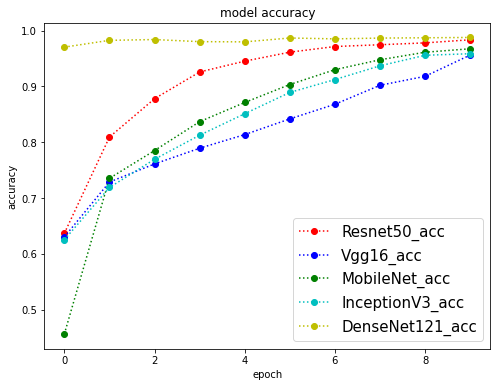

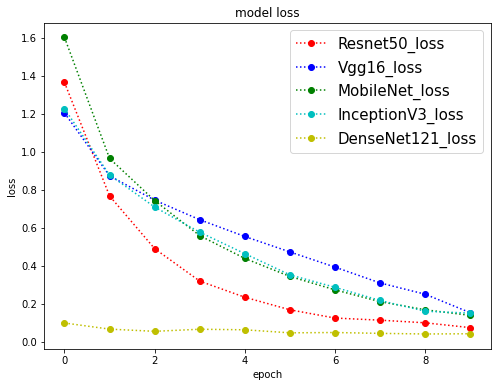

In [80]:
# summarize history for accuracy
plt.rcParams["figure.figsize"] = (8,6)
plt.plot(history.history['accuracy'] ,'o:r')
plt.plot(history_vgg16.history['accuracy'] ,'o:b')
plt.plot(history_MobileNet.history['accuracy'] ,'o:g')
plt.plot(history_InceptionV3.history['accuracy'] ,'o:c')
plt.plot(history_DenseNet121.history['accuracy'] ,'o:y')


#********************************************************
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Resnet50_acc',"Vgg16_acc","MobileNet_acc","InceptionV3_acc","DenseNet121_acc"], loc='lower right',prop={'size': 15})
plt.show()

# summarize history for loss
plt.plot(history.history['loss'] ,'o:r')
plt.plot(history_vgg16.history['loss'] ,'o:b')
plt.plot(history_MobileNet.history['loss'] ,'o:g')
plt.plot(history_InceptionV3.history['loss'] ,'o:c')
plt.plot(history_DenseNet121.history['loss'] ,'o:y')

#********************************************************
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Resnet50_loss',"Vgg16_loss","MobileNet_loss","InceptionV3_loss","DenseNet121_loss"], loc='upper right',prop={'size': 15})
plt.show()